# Elmy Data Challenge ENS
## Testing Models

In [1]:
import os 
import datetime
from tqdm import tqdm

import pandas as pd
import numpy as np 
import json

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

from sklearn.decomposition import PCA

## Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso 
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


## Classification Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from scipy.optimize import minimize

from elmy_helper import custom_weighted_accuracy

Before working on our models, we need to remember that the scoring function for this specific problem is not usual. Indeed instead of a RMSE or accuracy, our custom metric is the following : 
$$
\begin{equation*}
    f \left( y_{true}, y_{pred} \right) = \frac{\sum_{j=1}^{N} 1_{sign(y_{true,j}) =  sign(y_{pred,j}) } |y_{true,j} | }{ \sum_{j=1}^{N} |y_{true,j}|}
\end{equation*}
$$

In [2]:
file_path_X_train_raw = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))+ "/datasets/elmy_spot_vs_intraday/raw_data/X_train.csv"

file_path_X_train_first_preprocess = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))+ "/datasets/elmy_spot_vs_intraday/processed_data/first_preprocess/X_train_first_preprocess.csv"
file_path_X_test_first_preprocess = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))+ "/datasets/elmy_spot_vs_intraday/processed_data/first_preprocess/X_test_first_preprocess.csv"

file_path_X_train_second_preprocess = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))+ "/datasets/elmy_spot_vs_intraday/processed_data/second_preprocess/X_train_second_preprocess.csv"
file_path_X_test_second_preprocess = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))+ "/datasets/elmy_spot_vs_intraday/processed_data/second_preprocess/X_test_second_preprocess.csv"

file_path_y_train_raw = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))+ "/datasets/elmy_spot_vs_intraday/raw_data/y_train.csv" 

In [3]:
X_train_raw = pd.read_csv(file_path_X_train_raw)
X_train_first_preprocess = pd.read_csv(file_path_X_train_first_preprocess)
X_train_second_preprocess = pd.read_csv(file_path_X_train_second_preprocess)

X_test_second_preprocess = pd.read_csv(file_path_X_test_second_preprocess)
y_train = pd.read_csv(file_path_y_train_raw)

In [4]:
X_train_second_preprocess.drop(columns = ['DELIVERY_START'], axis = 1, inplace = True)
X_test_second_preprocess.drop(columns = ['DELIVERY_START'], axis = 1, inplace = True)
X_test_second_preprocess.drop(columns = ['predicted_spot_price'], axis = 1, inplace = True)

In [5]:
X_train_raw.shape

(10605, 10)

In [6]:
scorer_weighted_accuracy = make_scorer(custom_weighted_accuracy, response_method="predict", greater_is_better=True)

In [7]:
dic_regression_models = {
    "Linear Regression" : LinearRegression(),
    "Ridge Linear Regression" : Ridge(),
    "Lasso Linear Regression" : Lasso(),
    "Elastic Net Regression" : ElasticNet(),
    "Decision Tree Regressor" : DecisionTreeRegressor(),
    "KNN Regressor" : KNeighborsRegressor(),
    "Support Vector Regression" : SVR(),
    "Random Forest Regressor" : RandomForestRegressor(),
    "Xgboost Regressor" : XGBRegressor(),
    "Catboost Regressor" : CatBoostRegressor(allow_writing_files=False, logging_level = 'Silent')
}

In [8]:
X_train_raw.drop(columns=['predicted_spot_price'], axis=1, inplace=True)
X_train_raw.dropna(inplace = True)
X_train_raw.drop(columns = ['DELIVERY_START'], axis = 1, inplace = True)

y_train_raw_regression = y_train.loc[X_train_raw.index,"spot_id_delta"]

In [9]:
X_train_raw.shape

(9269, 8)

In [10]:
X_train_raw

load_forecast  coal_power_available  gas_power_available  \
0            49439.0                3386.0              11487.0   
1            46511.0                3386.0              11487.0   
2            45158.0                3386.0              11487.0   
3            44779.0                3386.0              11487.0   
4            45284.0                3386.0              11487.0   
...              ...                   ...                  ...   
10600        50814.0                3386.0              11952.0   
10601        50628.0                3386.0              11952.0   
10602        48201.0                3386.0              11952.0   
10603        47967.0                3386.0              11952.0   
10604        48444.0                3386.0              11952.0   

       nucelear_power_available  wind_power_forecasts_average  \
0                       44118.0                        3035.0   
1                       44118.0                        3143.0   
2                       44118.0                        3288.0   
3                       44118.0                        3447.0   
4                       44118.0                        3679.0   
...                         ...                           ...   
10600                   38320.0                        7552.0   
10601                   38320.0                        8338.0   
10602                   38320.0                        9115.0   
10603                   38320.0                        9636.0   
10604                   38320.0                       10140.0   

       solar_power_forecasts_average  wind_power_forecasts_std  \
0                                0.0                 79.248348   
1                                0.0                 61.776532   
2                                0.0                 44.291112   
3                                0.0                 36.127588   
4                                0.0                 30.983023   
...                              ...                       ...   
10600                          651.0                247.408490   
10601                          109.0                155.795012   
10602                            0.0                126.884684   
10603                            0.0                156.669189   
10604                            0.0                204.124773   

       solar_power_forecasts_std  
0                       0.000000  
1                       0.000000  
2                       0.000000  
3                       0.000000  
4                       0.000000  
...                          ...  
10600                   7.821622  
10601                   2.534054  
10602                   0.000000  
10603                   0.000000  
10604                   0.000000  

[9269 rows x 8 columns]

In [11]:
dic_model_regression_scores = {}
ts_split = TimeSeriesSplit(n_splits=5)
for model_name, model in tqdm(dic_regression_models.items(), desc="Evaluating Models"):
    dic_model_regression_scores[model_name] = np.mean(
        cross_val_score(
            model,
            X_train_raw,
            y_train_raw_regression,
            cv=ts_split,
            scoring=scorer_weighted_accuracy
        )
    )

Evaluating Models: 100%|██████████| 10/10 [00:19<00:00,  1.99s/it]


In [12]:
df_score_regression_raw_data = pd.DataFrame(dic_model_regression_scores, index = ["weighted_accuracy"]).T
df_score_regression_raw_data.sort_values(by = "weighted_accuracy", ascending = False)

weighted_accuracy
Elastic Net Regression              0.529827
Lasso Linear Regression             0.529382
Linear Regression                   0.529237
Ridge Linear Regression             0.529237
KNN Regressor                       0.514523
Decision Tree Regressor             0.509996
Xgboost Regressor                   0.504837
Catboost Regressor                  0.499466
Random Forest Regressor             0.495378
Support Vector Regression           0.490097

In [13]:
X_train_first_preprocess.drop(columns=['predicted_spot_price'], axis=1, inplace=True)
X_train_first_preprocess.dropna(inplace = True)
X_train_first_preprocess.drop(columns = ['DELIVERY_START'], axis = 1, inplace = True)

y_train_first_preprocess = y_train.loc[X_train_first_preprocess.index,"spot_id_delta"]

In [14]:
dic_model_regression_scores = {}
ts_split = TimeSeriesSplit(n_splits=5)

with tqdm(total=len(dic_regression_models), desc="Evaluating Models") as pbar:
    for model_name, model in dic_regression_models.items():
        pbar.set_postfix({"Current Model": model_name}) 
        dic_model_regression_scores[model_name] = np.mean(
            cross_val_score(
                model,
                X_train_first_preprocess,
                y_train_first_preprocess,
                cv=ts_split,
                scoring=scorer_weighted_accuracy
            )
        )
        pbar.update(1) 

Evaluating Models: 100%|██████████| 10/10 [00:21<00:00,  2.20s/it, Current Model=Catboost Regressor]      


In [15]:
df_score_regression_first_preprocess = pd.DataFrame(dic_model_regression_scores, index = ["weighted_accuracy"]).T
df_score_regression_first_preprocess.sort_values(by = "weighted_accuracy", ascending = False)

weighted_accuracy
Decision Tree Regressor             0.521576
Random Forest Regressor             0.519366
Xgboost Regressor                   0.518789
KNN Regressor                       0.514728
Lasso Linear Regression             0.497779
Ridge Linear Regression             0.497389
Linear Regression                   0.497261
Elastic Net Regression              0.496975
Catboost Regressor                  0.494951
Support Vector Regression           0.488719

In [17]:
X_train_second_preprocess.dropna(inplace = True)
y_train_second_preprocess = y_train.loc[X_train_second_preprocess.index,"spot_id_delta"]

In [18]:
dic_model_regression_scores = {}
ts_split = TimeSeriesSplit(n_splits=5)

with tqdm(total=len(dic_regression_models), desc="Evaluating Models") as pbar:
    for model_name, model in dic_regression_models.items():
        pbar.set_postfix({"Current Model": model_name}) 
        dic_model_regression_scores[model_name] = np.mean(
            cross_val_score(
                model,
                X_train_first_preprocess,
                y_train_first_preprocess,
                cv=ts_split,
                scoring=scorer_weighted_accuracy
            )
        )
        pbar.update(1) 

Evaluating Models: 100%|██████████| 10/10 [00:23<00:00,  2.30s/it, Current Model=Catboost Regressor]      


In [19]:
df_score_regression_second_preprocess = pd.DataFrame(dic_model_regression_scores, index = ["weighted_accuracy"]).T
df_score_regression_second_preprocess.sort_values(by = "weighted_accuracy", ascending = False)

weighted_accuracy
Decision Tree Regressor             0.528055
Random Forest Regressor             0.526107
Xgboost Regressor                   0.518789
KNN Regressor                       0.514728
Lasso Linear Regression             0.497779
Ridge Linear Regression             0.497389
Linear Regression                   0.497261
Elastic Net Regression              0.496975
Catboost Regressor                  0.494951
Support Vector Regression           0.488719

In [20]:
X_train_second_preprocess

load_forecast  coal_power_available  gas_power_available  \
24           48690.0                2226.0              11487.0   
25           45866.0                2226.0              11487.0   
26           44697.0                2226.0              11487.0   
27           44679.0                3386.0              11487.0   
28           45234.0                3386.0              11487.0   
...              ...                   ...                  ...   
10600        50814.0                3386.0              11952.0   
10601        50628.0                3386.0              11952.0   
10602        48201.0                3386.0              11952.0   
10603        47967.0                3386.0              11952.0   
10604        48444.0                3386.0              11952.0   

       nucelear_power_available  wind_power_forecasts_average  \
24                      43371.0                        6110.0   
25                      43501.0                        6457.0   
26                      44416.0                        6856.0   
27                      44416.0                        7283.0   
28                      44416.0                        7880.0   
...                         ...                           ...   
10600                   38320.0                        7552.0   
10601                   38320.0                        8338.0   
10602                   38320.0                        9115.0   
10603                   38320.0                        9636.0   
10604                   38320.0                       10140.0   

       solar_power_forecasts_average  wind_power_forecasts_std  \
24                               0.0                 85.756533   
25                               0.0                219.432371   
26                               0.0                286.658231   
27                               0.0                312.730945   
28                               0.0                237.518847   
...                              ...                       ...   
10600                          651.0                247.408490   
10601                          109.0                155.795012   
10602                            0.0                126.884684   
10603                            0.0                156.669189   
10604                            0.0                204.124773   

       solar_power_forecasts_std  hour  day_of_week  ...  \
24                      0.000000     1            6  ...   
25                      0.000000     2            6  ...   
26                      0.000000     3            6  ...   
27                      0.000000     4            6  ...   
28                      0.000000     5            6  ...   
...                          ...   ...          ...  ...   
10600                   7.821622    17            2  ...   
10601                   2.534054    18            2  ...   
10602                   0.000000    19            2  ...   
10603                   0.000000    20            2  ...   
10604                   0.000000    21            2  ...   

       rolling::avg_gas_power_available__lag_21_days  \
24                                      11487.000000   
25                                      11487.000000   
26                                      11487.000000   
27                                      11487.000000   
28                                      11487.000000   
...                                              ...   
10600                                   11923.857143   
10601                                   11923.857143   
10602                                   11923.857143   
10603                                   11923.857143   
10604                                   11923.857143   

       rolling::avg_nucelear_power_available__lag_7_days  \
24                                          44118.000000   
25                                          44118.000000   
26                                          44118.0000

In [21]:
X_train_second_preprocess

load_forecast  coal_power_available  gas_power_available  \
24           48690.0                2226.0              11487.0   
25           45866.0                2226.0              11487.0   
26           44697.0                2226.0              11487.0   
27           44679.0                3386.0              11487.0   
28           45234.0                3386.0              11487.0   
...              ...                   ...                  ...   
10600        50814.0                3386.0              11952.0   
10601        50628.0                3386.0              11952.0   
10602        48201.0                3386.0              11952.0   
10603        47967.0                3386.0              11952.0   
10604        48444.0                3386.0              11952.0   

       nucelear_power_available  wind_power_forecasts_average  \
24                      43371.0                        6110.0   
25                      43501.0                        6457.0   
26                      44416.0                        6856.0   
27                      44416.0                        7283.0   
28                      44416.0                        7880.0   
...                         ...                           ...   
10600                   38320.0                        7552.0   
10601                   38320.0                        8338.0   
10602                   38320.0                        9115.0   
10603                   38320.0                        9636.0   
10604                   38320.0                       10140.0   

       solar_power_forecasts_average  wind_power_forecasts_std  \
24                               0.0                 85.756533   
25                               0.0                219.432371   
26                               0.0                286.658231   
27                               0.0                312.730945   
28                               0.0                237.518847   
...                              ...                       ...   
10600                          651.0                247.408490   
10601                          109.0                155.795012   
10602                            0.0                126.884684   
10603                            0.0                156.669189   
10604                            0.0                204.124773   

       solar_power_forecasts_std  hour  day_of_week  ...  \
24                      0.000000     1            6  ...   
25                      0.000000     2            6  ...   
26                      0.000000     3            6  ...   
27                      0.000000     4            6  ...   
28                      0.000000     5            6  ...   
...                          ...   ...          ...  ...   
10600                   7.821622    17            2  ...   
10601                   2.534054    18            2  ...   
10602                   0.000000    19            2  ...   
10603                   0.000000    20            2  ...   
10604                   0.000000    21            2  ...   

       rolling::avg_gas_power_available__lag_21_days  \
24                                      11487.000000   
25                                      11487.000000   
26                                      11487.000000   
27                                      11487.000000   
28                                      11487.000000   
...                                              ...   
10600                                   11923.857143   
10601                                   11923.857143   
10602                                   11923.857143   
10603                                   11923.857143   
10604                                   11923.857143   

       rolling::avg_nucelear_power_available__lag_7_days  \
24                                          44118.000000   
25                                          44118.000000   
26                                          44118.0000

In [22]:
dic_regression_models['Xgboost Regressor'].fit(X_train_second_preprocess,y_train_second_preprocess)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Text(0.5, 0, 'Xgboost Feature Importance')

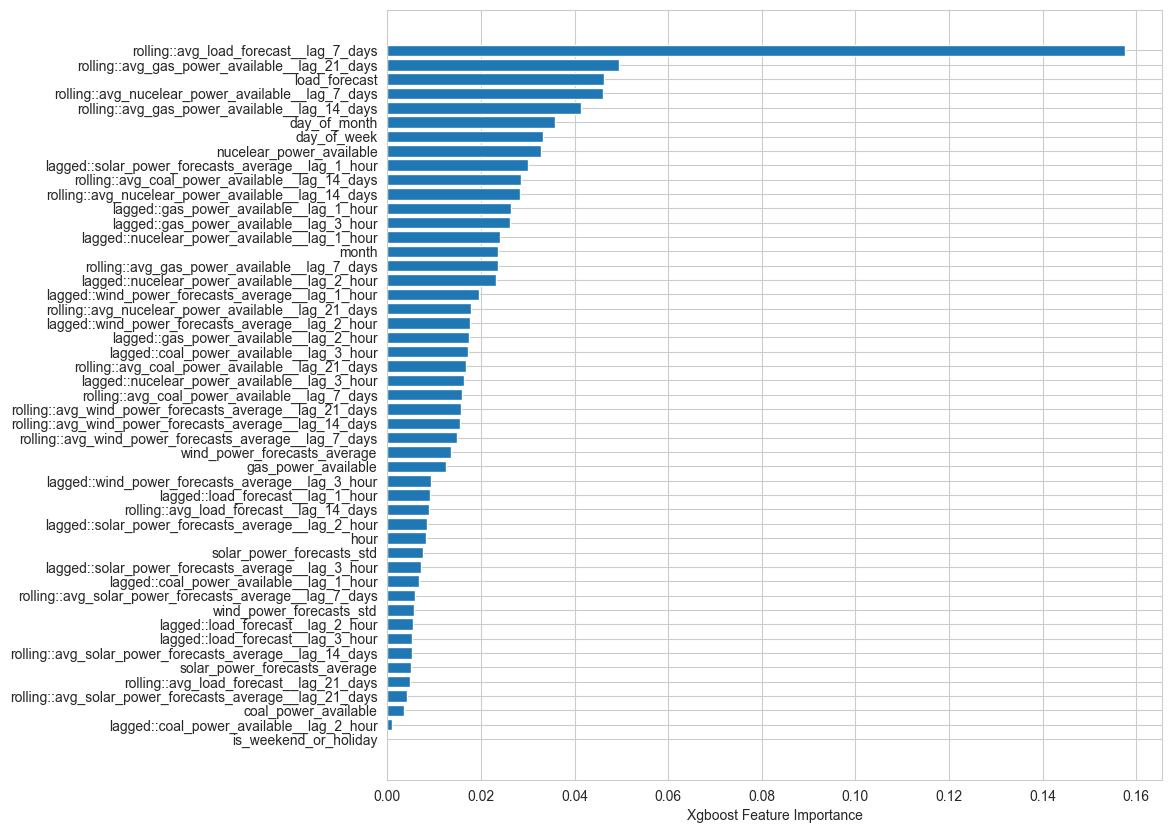

In [23]:
fig = plt.figure(figsize = (10,10))

sorted_idx =dic_regression_models['Xgboost Regressor'].feature_importances_.argsort()
plt.barh(X_train_second_preprocess.columns[sorted_idx], dic_regression_models['Xgboost Regressor'].feature_importances_[sorted_idx])

plt.xlabel("Xgboost Feature Importance")

# Fine tuning

In [24]:
X_train_raw = pd.read_csv(file_path_X_train_raw)
X_train_first_preprocess = pd.read_csv(file_path_X_train_first_preprocess)
X_train_second_preprocess = pd.read_csv(file_path_X_train_second_preprocess)

X_test_second_preprocess = pd.read_csv(file_path_X_test_second_preprocess)
y_train = pd.read_csv(file_path_y_train_raw)

In [25]:
X_train_second_preprocess.drop(columns = ['DELIVERY_START'], axis = 1, inplace = True)
X_test_second_preprocess.drop(columns = ['DELIVERY_START'], axis = 1, inplace = True)
X_test_second_preprocess.drop(columns = ['predicted_spot_price'], axis = 1, inplace = True)

In [58]:
param_grid = {
     'booster' :  ["gbtree","dart"],
    "reg_lambda" : np.linspace(0.01,2,4),
    'n_estimators': [50, 80, 100,150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma' : [0, 0.1, 0.5]
}

In [59]:
train_size = int(0.8 * len(X_train_second_preprocess))
X_train_train, X_test_train = X_train_second_preprocess[:train_size], X_train_second_preprocess[train_size:]
y_train_train, y_test_train = y_train_second_preprocess[:train_size], y_train_second_preprocess[train_size:]

In [60]:
model = XGBRegressor(objective= 'reg:squarederror', random_state=42)
tscv = TimeSeriesSplit(n_splits=5)

In [67]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring= scorer_weighted_accuracy,
    cv=tscv,
    verbose=3,
    n_jobs=-1
)

In [ ]:
grid_search.fit(X_train_train, y_train_train)

Fitting 5 folds for each of 7680 candidates, totalling 38400 fits
[CV 2/5] END booster=gbtree, colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=0.01, subsample=0.8;, score=0.266 total time=   0.1s
[CV 2/5] END booster=gbtree, colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=0.6733333333333333, subsample=1.0;, score=0.266 total time=   0.1s
[CV 4/5] END booster=gbtree, colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1.3366666666666667, subsample=0.8;, score=0.463 total time=   0.1s
[CV 5/5] END booster=gbtree, colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.01, reg_lambda=2.0, subsample=0.8;, score=0.450 total time=   0.1s
[CV 1/5] END booster=gbtree, colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.6733333333333333, reg_lambda=0.01, subsample=1.0;, score=0.320 total t

In [ ]:
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

In [32]:
y_pred_train = best_model.predict(X_train_train)
y_pred_test = best_model.predict(X_test_train)

In [33]:
train_weight_accuracy = custom_weighted_accuracy(y_train_train, y_pred_train)
test_weight_accuracy = custom_weighted_accuracy(y_test_train, y_pred_test)

ValueError: ('Lengths must match to compare', (703,), (2121,))

In [40]:
y_pred_test.shape

(2121,)

In [ ]:
train_weight_accuracy

In [ ]:
test_weight_accuracy

In [ ]:
best_model.predict(X_test_second_preprocess)

In [ ]:
X_test_second_preprocess